## Moonboard Sequence Simulator

MoonboardSequenceSimulator

Input:
- Single moonboard problem from `"MoonBoard_2016_raw"` to get url
- processed data `processed_data_xy_mode`. It will be neater to read directly from `"MoonBoard_2016_raw"` `[(six hand feature) X, Y, isStart, isFinish]`
- Table for each hold's right/left hand difficulty

Output:

hand sequence generator:
- Predict a reasonable hand sequence for each problem. 
- i.e. 5B-R (Start) 7C-L (Start) 6A-R 8B-L 9C-L ... 18B-L 18B-R(Finished)
- return an array with `[RH, RH, LH,......]` and all holds in used along the way    

move sequence generator:
- A list of moves. `[move1, move2, move3...]`
- Each move is a dictionary. i.e.
- ```py
  {
    'TargetHoldString': 'F6',
    'TargetHoldHand': 'RH',
    'TargetHoldScore': array([1]),
    'RemainingHoldString': 'B4',
    'RemainingHoldHand': 'LH',
    'RemainingHoldScore': array([6]),
    'dxdyRtoT': (4.0, 2.0),
    'MovingHoldString': 'D3',
    'MovingHoldHand': 'RH',
    'MovingHoldScore': array([3]),
    'dxdyMtoT': (2.0, 3.0),
    'FootPlacement': [0, 0, 0, 1, 1, 1, 0]
  }
  ```
    
Author: Yi-Shiou Duh (allenduh@stanford.edu)

In [ ]:
import numpy as np
import copy
import pickle
import heapq
import matplotlib.pyplot as plt
import pandas as pd
from preprocessing_helper import *

import constants

## 1. Read all preprocessed data


### 1-1. Read hand feature files

In [2]:
# left/right hand features are single difficulties (0-9) for each hold
LeftHandfeatures = pd.read_csv(constants.HOLD_FEATURES_LEFT_HAND_PATH, dtype=str)
RightHandfeatures = pd.read_csv(constants.HOLD_FEATURES_RIGHT_HAND_PATH, dtype=str)

# convert features from pd dataframe to dictionary of left and right hand
# key: (x,y) value: difficulty
RightHandfeature_dict = {}
LeftHandfeature_dict = {}
for index in RightHandfeatures.index:
    LeftHandfeature_item = LeftHandfeatures.loc[index]
    LeftHandfeature_dict[(int(LeftHandfeature_item['X_coord']), int(LeftHandfeature_item['Y_coord']))] = np.array(
        list(LeftHandfeature_item['Difficulties'])).astype(int)
    RightHandfeature_item = RightHandfeatures.loc[index]
    RightHandfeature_dict[(int(RightHandfeature_item['X_coord']), int(RightHandfeature_item['Y_coord']))] = np.array(
        list(RightHandfeature_item['Difficulties'])).astype(int)

next(iter(RightHandfeature_dict.items()))

((0, 17), array([5]))

### 1-2. Read moonboard problems with url file

In [3]:
# load the scraped MoonBoard json (dict)
with open(constants.DATA_DIR / 'moonGen_scrape_2016_cp', 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)
next(iter(MoonBoard_2016_withurl.items()))

('367894',
 {'problem_name': 'TALL POPPY',
  'info': ['halladay',
   'Be the first to repeat this problem',
   '6C+',
   'Feet follow hands',
   ''],
  'url': 'https://moonboard.com/Problems/View/367894/tall-poppy',
  'num_empty': 3,
  'num_stars': 0,
  'moves': [{'Id': 2119224,
    'Description': 'F5',
    'IsStart': True,
    'IsEnd': False},
   {'Id': 2119225, 'Description': 'G2', 'IsStart': True, 'IsEnd': False},
   {'Id': 2119226, 'Description': 'H10', 'IsStart': False, 'IsEnd': False},
   {'Id': 2119227, 'Description': 'B11', 'IsStart': False, 'IsEnd': False},
   {'Id': 2119228, 'Description': 'E15', 'IsStart': False, 'IsEnd': False},
   {'Id': 2119229, 'Description': 'D18', 'IsStart': False, 'IsEnd': True},
   {'Id': 2119230, 'Description': 'E8', 'IsStart': False, 'IsEnd': False}],
  'grade': '6C+',
  'UserGrade': None,
  'isBenchmark': False,
  'repeats': 0,
  'ProblemType': None,
  'IsMaster': False,
  'setter': {'Id': '93A38FE2-1B2B-4B0F-9B70-9A77BAE976B8',
   'Nickname': 'ha

### 1-3. Read preprocessed moonboard problem

Load the reformatted data dict of dicts (X/Y, un/benchmarked, un/user-graded)

Dicts:
- `X_dict_benchmark_withgrade`
- `Y_dict_benchmark_withgrade`
- `X_dict_benchmark_nograde`
- `Y_dict_benchmark_nograde`
- `X_dict_withgrade`
- `Y_dict_withgrade`
- `X_dict_nograde`
- `Y_dict_nograde`

Where each X item is (problem_id, 10xn array) where n is the number of holds in the problem. Each **column** vector contain:
- 0: `feature_dict[x,y][0]`
- 1: `feature_dict[x,y][1]`
- 2: `feature_dict[x,y][2]`
- 3: `feature_dict[x,y][3]`
- 4: `feature_dict[x,y][4]`
- 5: `feature_dict[x,y][5]`
- 6: `x`
- 7: `y`
- 8: `is_start`
- 9: `is_end`

Y items (problem_id, 3x1 array). Each **column** vector contain:
- 0: `grade`
- 1: `is_benchmarked`
- 2: `user_grade` (only if dict is `withgrade`)

In [4]:
with open(constants.PREPROCESSING_DIR / 'processed_data_xy_mode', 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)

In [5]:
next(iter(MoonBoard_2016_raw['X_dict_benchmark_withgrade'].items()))

('337509',
 array([[ 0.,  2.,  0.,  1.,  2.,  3.],
        [ 2.,  5.,  1.,  5.,  3.,  7.],
        [ 5.,  2.,  4.,  3.,  4.,  5.],
        [ 2.,  0.,  1.,  1.,  2.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [10.,  5.,  8.,  5.,  3.,  1.],
        [ 4.,  6., 10., 13., 16., 17.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]))

#### Here you can see the possible range of next right hand using sum of two Gaussisan. Remaining left hand in origin

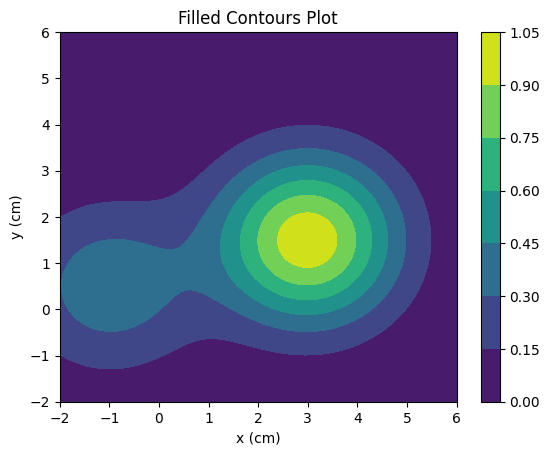

In [6]:
# generate axis ranges
xlist = np.linspace(-2,6, 100)
ylist = np.linspace(-2,6, 100)
X, Y = np.meshgrid(xlist, ylist)

# generate Gaussian of to evaluate possiblitity of distance from current hand
# TODO: surely this is a poor approximation of where to put hands, as it should be much easier next to current hand
Z = makeGaussian(targetXY=(X,Y), fwhm=3, center=(0,0), lasthand='LH')

# plot
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_ylabel('y (cm)')
ax.set_xlabel('x (cm)')
plt.show()

## 2. Demonstration of detailed analysis on a single problem

### 2-1. load one specific problem

In [7]:
keyNum = "342797"    
moonboardTest = (MoonBoard_2016_raw["X_dict_withgrade"])[keyNum]

In [8]:
# Can see problem has 9 holds (columns)
moonboardTest

array([[ 5.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  2.],
       [ 4.,  2.,  5.,  0.,  0.,  3.,  4.,  5.,  6.],
       [ 9.,  4.,  2.,  4.,  6.,  6.,  3.,  2.,  8.],
       [ 4.,  2.,  0.,  9.,  4.,  3.,  1.,  1.,  6.],
       [ 1.,  0.,  0.,  4.,  4.,  0.,  0.,  0.,  2.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  4.,  0.,  7.,  3.,  4.,  2.,  1.,  3.],
       [ 4.,  7.,  8.,  9., 11., 12., 14., 15., 17.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [9]:
# Create betas for right and left hands (transpose the matrices so each row is a hold)
testbeta = beta(moonboardTest.T)
status = [beta(moonboardTest.T), beta(moonboardTest.T)]

# Print details
print("keyNum = ", keyNum)
print(status[0].allHolds)
moonboardTestUrl = MoonBoard_2016_withurl[keyNum]
print(moonboardTestUrl["url"])

# Initialized Start hold of two different beta
status[0].addStartHolds(0)
status[1].addStartHolds(1)

operationList = ["RH", "LH"]
tempstatus = []
tempstatus2 = []
tempstatus3 = []
distanceScore = []

keyNum =  342797
[[ 5.  4.  9.  4.  1.  1.  5.  4.  1.  0.]
 [ 0.  2.  4.  2.  0.  0.  4.  7.  0.  0.]
 [ 1.  5.  2.  0.  0.  0.  0.  8.  0.  0.]
 [ 0.  0.  4.  9.  4.  0.  7.  9.  0.  0.]
 [ 0.  0.  6.  4.  4.  0.  3. 11.  0.  0.]
 [ 0.  3.  6.  3.  0.  0.  4. 12.  0.  0.]
 [ 1.  4.  3.  1.  0.  0.  2. 14.  0.  0.]
 [ 2.  5.  2.  1.  0.  0.  1. 15.  0.  0.]
 [ 2.  6.  8.  6.  2.  0.  3. 17.  0.  1.]]
https://moonboard.com/Problems/View/342797/chats


### 2-2. Beamer search process 

In [10]:
# Add moves between each hold
totalRun = status[0].totalNumOfHold - 1
for i in range(totalRun):
    print (i)
    # Expand the current beta (LH&RH) by finding moves to next hold
    status = addNewBeta(status)

    # Compute success scores of each move
    finalScore = []
    for i in status:
        finalScore.append(i.overallSuccessRate())
    
    # Find 5 best moves check if we're finished
    largestIndex = heapq.nlargest(4, range(len(finalScore)), key=finalScore.__getitem__)
    if (status[largestIndex[0]].isFinished and status[largestIndex[1]].isFinished) == True:
        break

0
[0, 0, 1] ['LH', 'RH', 'LH'] [147.09694124]
[0, 0, 1] ['LH', 'RH', 'LH'] [147.09694124]
[0, 0, 1] ['LH', 'RH', 'RH'] [92.60035394]
[0, 0, 1] ['LH', 'RH', 'RH'] [92.60035394]
[0, 0, 2] ['LH', 'RH', 'LH'] [65.32602493]
[0, 0, 2] ['LH', 'RH', 'LH'] [65.32602493]
[0, 0, 3] ['LH', 'RH', 'RH'] [54.2957249]
[0, 0, 3] ['LH', 'RH', 'RH'] [54.2957249]
1
[0, 0, 1, 3] ['LH', 'RH', 'LH', 'RH'] [207.39931721]
[0, 0, 1, 3] ['LH', 'RH', 'LH', 'RH'] [207.39931721]
[0, 0, 1, 2] ['LH', 'RH', 'RH', 'LH'] [106.39664984]
[0, 0, 1, 2] ['LH', 'RH', 'RH', 'LH'] [106.39664984]
[0, 0, 2, 4] ['LH', 'RH', 'LH', 'RH'] [58.83563347]
[0, 0, 2, 4] ['LH', 'RH', 'LH', 'RH'] [58.83563347]
[0, 0, 3, 4] ['LH', 'RH', 'RH', 'LH'] [57.45155419]
[0, 0, 3, 4] ['LH', 'RH', 'RH', 'LH'] [57.45155419]
2
[0, 0, 1, 3, 4] ['LH', 'RH', 'LH', 'RH', 'LH'] [165.96935332]
[0, 0, 1, 3, 4] ['LH', 'RH', 'LH', 'RH', 'LH'] [165.96935332]
[0, 0, 1, 3, 5] ['LH', 'RH', 'LH', 'RH', 'LH'] [151.39323371]
[0, 0, 1, 3, 5] ['LH', 'RH', 'LH', 'RH', 'LH

In [11]:
# last sorting for the best 5
finalScore = [] 
print(status)
for i in status:   
    finalScore.append(i.overallSuccessRate())   
largestIndex = heapq.nlargest(4, range(len(finalScore)), key=finalScore.__getitem__)

[<preprocessing_helper.beta object at 0x0000017872170AD0>, <preprocessing_helper.beta object at 0x00000178055D4FD0>, <preprocessing_helper.beta object at 0x0000017805542250>, <preprocessing_helper.beta object at 0x0000017862F85CD0>, <preprocessing_helper.beta object at 0x0000017805657310>, <preprocessing_helper.beta object at 0x0000017805561710>, <preprocessing_helper.beta object at 0x0000017805562AD0>, <preprocessing_helper.beta object at 0x0000017805563310>]


In [12]:
print(moonboardTestUrl["url"])
print ("After Beamer search, the most possible hand sequence and the successRate:")
for i in largestIndex:
    print(status[i].handSequence, status[i].handOperator, status[i].overallSuccessRate())    

https://moonboard.com/Problems/View/342797/chats
After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 1, 3, 4, 5, 7, 8] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH', 'RH'] [98.50396893]
[0, 0, 1, 3, 4, 5, 7, 8] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH', 'RH'] [98.50396893]
[0, 0, 1, 3, 4, 5, 7, 8] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH', 'RH'] [98.50396893]
[0, 0, 1, 3, 4, 5, 7, 8] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH', 'RH'] [98.50396893]


### 2-3. Here you can find one problem's best hand sequence. Feel free to change key to see other result

To find other keys, try `MoonBoard_2016_raw["X_dict_benchmark_withgrade"].keys()`

In [13]:
# The above as a function
produce_sequence("20149", MoonBoard_2016_raw["X_dict_benchmark_withgrade"], n_return = 1, printout = True)

After Beamer search, the most possible hand sequence and the successRate:
['J5', 'G6', 'A9', 'F11', 'C13', 'A14', 'D18']
[0, 1, 2, 4, 5, 6, 7] ['LH', 'RH', 'LH', 'RH', 'LH', 'LH', 'RH'] [6.55920813]


{0: <preprocessing_helper.beta at 0x17808229f50>}

#### I check the hand sequence of 20 problem. 90% are exactly same with human's prediction. Other 10% are acceptable sequence. Next we will start generate move sequence

## 3. Process the entire dataset and save the results
For the output of this part, each move is represented as 22x1 vector

In [17]:
save_path = constants.PREPROCESSING_DIR / 'benchmark_withgrade_move_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_benchmark_withgrade"]
print(f"Processing {len(processed_data)} problems")
output, fail_list = moveGeneratorForAllProblem(processed_data, save_path, print_result = False)
print(fail_list)

Processing 359 problems
Raw data with key 23360 contains error
result saved.
[('23360', TypeError('only size-1 arrays can be converted to Python scalars'))]


In [18]:
save_path = constants.PREPROCESSING_DIR / 'benchmark_withgrade_move_seq_Y'
processed_data_Y = MoonBoard_2016_raw["Y_dict_benchmark_withgrade"]
print(f"Processing {len(processed_data_Y)} problems")
output, fail_list = gradeTransFromFontToV(processed_data_Y, save_path)
print(fail_list)

Processing 359 problems
result saved.
[]


In [19]:
save_path = constants.PREPROCESSING_DIR / 'benchmark_nograde_move_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_benchmark_nograde"]
print(f"Processing {len(processed_data)} problems")
output, fail_list = moveGeneratorForAllProblem(processed_data, save_path, print_result = False)
print(fail_list)

Processing 9 problems
result saved.
[]


In [20]:
save_path = constants.PREPROCESSING_DIR / 'benchmark_nograde_move_seq_Y'
processed_data_Y = MoonBoard_2016_raw["Y_dict_benchmark_nograde"]
print(f"Processing {len(processed_data_Y)} problems")
output, fail_list = gradeTransFromFontToV(processed_data_Y, save_path)
print(fail_list)

Processing 9 problems
result saved.
[]


In [32]:
from importlib import reload
import preprocessing_helper
reload(preprocessing_helper)
from preprocessing_helper import moveGeneratorForAllProblem

In [33]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmark_withgrade_move_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_withgrade"]
print(f"Processing {len(processed_data)} problems")
output, fail_list = moveGeneratorForAllProblem(processed_data, save_path, print_result = True)
print(fail_list)

Processing 8605 problems
Complete 342797
Complete 342777
Complete 342750
Complete 342668
Complete 342655
Complete 342634
Complete 342633
Complete 342596
Complete 342556
Complete 342547
Complete 342543
Complete 342541
Complete 342526


c:\Users\valsp\source\repos\MoonBoardRNN\preprocessing\preprocessing_helper.py:491: RuntimeWarning: invalid value encountered in power
  print(f"overallScore: {overallScore}, numOfHand: {numOfHand}, ret: {ret}")


Complete 342512
Complete 342472
Complete 342469
Complete 342458
Complete 342455
Complete 342450
Complete 342396
Complete 342386
Complete 342357
Complete 342347
Complete 342343
Complete 342335
Complete 342300
Complete 342290
Complete 342288
Complete 342273
Complete 342270
Complete 342265
Complete 342256
Complete 342229
Complete 342221
Complete 342208
Complete 342206
Complete 342197
Complete 342179
Complete 342178
Complete 342157
Complete 342128
Complete 342117
Complete 342109
Complete 342105
Complete 342094
Complete 342092
Complete 342090
Complete 342089
Complete 342086
Complete 342071
Complete 342069
Complete 342065
Complete 342057
Complete 342032
Complete 342025
Complete 341985
Complete 341968
Complete 341966
Complete 341965
Complete 341960
Complete 341953
Complete 341952
Complete 341948
Complete 341944
Complete 341920
Complete 341918
Complete 341905
Complete 341900
Complete 341897
Complete 341881
Complete 341880
Complete 341879


KeyboardInterrupt: 

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmark_withgrade_move_seq_Y'
processed_data_Y = MoonBoard_2016_raw["Y_dict_withgrade"]
print(f"Processing {len(processed_data_Y)} problems")
output, fail_list = gradeTransFromFontToV(processed_data_Y, save_path)
print(fail_list)

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmark_nograde_move_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_nograde"]
print(f"Processing {len(processed_data)} problems")
output, fail_list = moveGeneratorForAllProblem(processed_data, save_path, print_result = False)
print(fail_list)

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmark_nograde_move_seq_Y'
processed_data_Y = MoonBoard_2016_raw["Y_dict_nograde"]
print(f"Processing {len(processed_data_Y)} problems")
output, fail_list = gradeTransFromFontToV(processed_data_Y, save_path)
print(fail_list)

## 4. Use pure hand sequence generator
The output of this part only contains the hand sequence, without other vectors

#### Test with one problem

In [ ]:
beamerBeta = produce_sequence("20149", MoonBoard_2016_raw["X_dict_benchmark_withgrade"], n_return = 1, printout = True)[0]
numOfMoves = len(beamerBeta.handSequence) 
routeHandSequence = beamerBeta.handSequence  
routeOpSequence = beamerBeta.handOperator 
handStringList = []

for orderOfHand in range(numOfMoves): 
    targetCoordinate = beamerBeta.getXYFromOrder(routeHandSequence[orderOfHand])
    newHandStr = coordinateToString(targetCoordinate) + "-" + routeOpSequence[orderOfHand]
    handStringList.append(newHandStr)
print(handStringList)    

#### Run through entire dataset for use with DeepRouteSet

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmarkNoGrade_handString_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_nograde"]
handStringSeqGeneratorForAllProblem(processed_data, save_path, print_result = True)

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'benchmark_handString_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_benchmark_withgrade"]
handStringSeqGeneratorForAllProblem(processed_data, save_path, print_result = True)

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'benchmarkNoGrade_handString_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_benchmark_nograde"]
handStringSeqGeneratorForAllProblem(processed_data, save_path, print_result = True)

In [ ]:
save_path = constants.PREPROCESSING_DIR / 'nonbenchmark_handString_seq_X'
processed_data = MoonBoard_2016_raw["X_dict_withgrade"]
handStringSeqGeneratorForAllProblem(processed_data, save_path, print_result = True)